# Foraminifera clusterization
## [GitHub: BenjaminGuzman](https://github.com/BenjaminGuzman)

In [1]:
import os
import cv2
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [2]:
SEGMENTED_CROPPED_DIR = os.path.abspath("img/segmented_cropped")
SEGMENTED_DIR = os.path.abspath("img/segmented")

## Analyze single image

In [20]:
img = cv2.imread("img/segmented_cropped/G. Bulloides/1.png")
print("---- BEFORE ----")
print("Image shape:", img.shape)
print("Image dtype: ", img.dtype)
print("Unique values", np.unique(img))

# Convert to float32 and scale to [0, 1]
img = img.astype(np.float32)
img /= 255

img = img.reshape(-1, 1) # flatten 
img = StandardScaler().fit_transform(img)

print("\n---- AFTER ----")
print("Image shape:", img.shape)
print("Image dtype: ", img.dtype)
print("Unique values", np.unique(img))

---- BEFORE ----
Image shape: (305, 309, 3)
Image dtype:  uint8
Unique values [  0  33  35  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51
  52  53  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69
  70  71  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87
  88  89  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105
 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123
 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141
 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159
 160 161 162 163 164 167 170]

---- AFTER ----
Image shape: (282735, 1)
Image dtype:  float32
Unique values [-1.2399514  -0.5846913  -0.54497856 -0.50526583 -0.48540947 -0.4655531
 -0.44569674 -0.42584038 -0.405984   -0.38612765 -0.3662713  -0.34641492
 -0.32655856 -0.3067022  -0.28684583 -0.26698947 -0.2471331  -0.22727674
 -0.20742038 -0.18756402 -0.16770765 -0.14785129 -0.12799492 -0.10813857
 -0.08828221

## Load images & convert to greyscale

`SEGMENTED_DIR` contains same shape images but with some black background that could affect later in the learning process, although I think PCA should get rid of such black background

Also, the max pooling layer(s) of the convnet help to get rid of the background?

In [ ]:
species_dirs = os.listdir(SEGMENTED_DIR)# os.listdir(SEGMENTED_CROPPED_DIR)

scaler = StandardScaler()
pca = PCA(0.9)
pca_r3 = PCA(n_components=3)

X_original = []
Y = []

k = 0
for i, specie_dir in enumerate(species_dirs):
    specie_dir_abspath = os.path.abspath("{}/{}".format(SEGMENTED_DIR, specie_dir))
    for j, img_file_str in enumerate(os.listdir(specie_dir_abspath)):
        file_path = "{}/{}".format(specie_dir_abspath, img_file_str)
        
        if not os.path.isfile(file_path):
            continue
            
        image = cv2.imread(file_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        image = cv2.resize(image, (400, 400))
        image = image.astype(np.float32)
        image /= 255
        image = scaler.fit_transform(image)
        
        if k >= BATCH_SIZE:
            break
        
        k += 1
        X_original.append(image.reshape(1, -1))
        Y.append(i) # append the specie "index" to Y, expected label
    break # load only first folder

In [ ]:
X_original = np.array(X_original)
print("X original shape", X_original.shape)
single_image_shape = X_original[0].shape
print("Single image shape", single_image_shape)

X_pca = pca.fit_transform(X_original[:, 0, :])
X_viz = pca_r3.fit_transform(X_original[:, 0, :])

In [ ]:
fig = plt.figure()
axes = fig.add_subplot(111, projection="3d")
axes.scatter(X_viz[:, 0], X_viz[:, 1], X_viz[:, 2])
axes.set_xlabel("Component 1")
axes.set_ylabel("Component 2")
axes.set_zlabel("Component 3")
axes.set_title("PCA, R3")
plt.show()

### TODO: load, split train & test, preprocess images

In [ ]:
BATCH_SIZE = 100

### Load dataset

!This takes about 11.2 Gb on RAM!

In [ ]:
species_dirs = os.listdir(SEGMENTED_DIR)# os.listdir(SEGMENTED_CROPPED_DIR)

scaler = StandardScaler()
pca = PCA(0.9)

X = []
Y = []

for i, specie_dir in enumerate(species_dirs):
    specie_dir_abspath = os.path.abspath("{}/{}".format(SEGMENTED_DIR, specie_dir))
    for j, img_file_str in enumerate(os.listdir(specie_dir_abspath)):
        file_path = "{}/{}".format(specie_dir_abspath, img_file_str)
        
        if not os.path.isfile(file_path):
            continue
            
        image = cv2.imread(file_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        image = cv2.resize(image, (400, 400))
        image = image.astype(np.float32)
        image /= 255
        image = scaler.fit_transform(image)
        
        X.append(image.reshape(1, -1))
        Y.append(i) # append the specie "index" to Y, expected label
    
    print("Loaded images from ", specie_dir_abspath)

### Preprocess

In [ ]:
X = pca.fit_transform(X[:, 0, :])

### Split: train & test dataset

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.33, random_state=42)

## Create ConvNet

In [ ]:
import keras
from keras.models import Sequential, Input, Model
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.layers.normalization import BatchNormalization
from keras.layers.advanced_activations import LeakyReLU

In [ ]:
model = Sequential()
# 32 = # filters (output of conv2D), how to select?
# how to select kernel size?
model.add(Conv2D(32, kernel_size=(5, 5), activation="sigmoid", input_shape=single_image_shape, padding="same"))

# how to select factors? in this case will downscale by a factor of 2
model.add(MaxPooling2D((2, 2), padding="same"))
model.add(Conv2D(64, kernel_size=(3, 3), activation="relu", padding="same"))
model.add(MaxPooling2D((2, 2), padding="same"))
model.add(Conv2D(128, kernel_size=(3, 3), activation="relu", padding="same"))
model.add(Flatten())
model.add(Dense(128, activation="relu"))
model.add(Dense(6, activation='softmax')) # 6 targets, G Bulloides, G. Ruber, G.....

In [158]:
X_original = np.array(X_original)
print("X original shape", X_original.shape)
single_image_shape = X_original[0].shape
print("Single image shape", single_image_shape)

X_pca = pca.fit_transform(X_original[:, 0, :])
X_viz = pca_r3.fit_transform(X_original[:, 0, :])

X original shape (100, 1, 160000)
Single image shape (1, 160000)


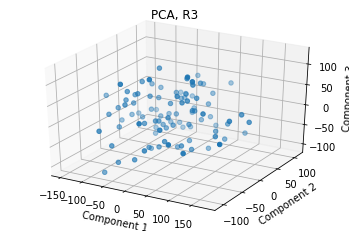

In [159]:
fig = plt.figure()
axes = fig.add_subplot(111, projection="3d")
axes.scatter(X_viz[:, 0], X_viz[:, 1], X_viz[:, 2])
axes.set_xlabel("Component 1")
axes.set_ylabel("Component 2")
axes.set_zlabel("Component 3")
axes.set_title("PCA, R3")
plt.show()

### TODO: load, split train & test, preprocess images

In [3]:
BATCH_SIZE = 100

### Load dataset

!This takes about 11.2 Gb on RAM!

In [3]:
species_dirs = os.listdir(SEGMENTED_DIR)# os.listdir(SEGMENTED_CROPPED_DIR)

scaler = StandardScaler()
pca = PCA(0.9)

X = []
Y = []

for i, specie_dir in enumerate(species_dirs):
    specie_dir_abspath = os.path.abspath("{}/{}".format(SEGMENTED_DIR, specie_dir))
    for j, img_file_str in enumerate(os.listdir(specie_dir_abspath)):
        file_path = "{}/{}".format(specie_dir_abspath, img_file_str)
        
        if not os.path.isfile(file_path):
            continue
            
        image = cv2.imread(file_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        image = cv2.resize(image, (400, 400))
        image = image.astype(np.float32)
        image /= 255
        image = scaler.fit_transform(image)
        
        X.append(image.reshape(1, -1))
        Y.append(i) # append the specie "index" to Y, expected label
    
    print("Loaded images from ", specie_dir_abspath)

Loaded images from  /remote/projects/foraminifera/img/segmented/N. Pachyderma
Loaded images from  /remote/projects/foraminifera/img/segmented/G. Sacculifer
Loaded images from  /remote/projects/foraminifera/img/segmented/N. Incompta
Loaded images from  /remote/projects/foraminifera/img/segmented/G. Ruber
Loaded images from  /remote/projects/foraminifera/img/segmented/N. Dutertrei
Loaded images from  /remote/projects/foraminifera/img/segmented/G. Bulloides


### Preprocess

In [ ]:
X = pca.fit_transform(X[:, 0, :])

### Split: train & test dataset

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.33, random_state=42)

## Create ConvNet

In [147]:
import keras
from keras.models import Sequential, Input, Model
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.layers.normalization import BatchNormalization
from keras.layers.advanced_activations import LeakyReLU

Using TensorFlow backend.


In [163]:
model = Sequential()
# 32 = # filters (output of conv2D), how to select?
# how to select kernel size?
model.add(Conv2D(32, kernel_size=(5, 5), activation="sigmoid", input_shape=single_image_shape, padding="same"))

# how to select factors? in this case will downscale by a factor of 2
model.add(MaxPooling2D((2, 2), padding="same"))
model.add(Conv2D(64, kernel_size=(3, 3), activation="relu", padding="same"))
model.add(MaxPooling2D((2, 2), padding="same"))
model.add(Conv2D(128, kernel_size=(3, 3), activation="relu", padding="same"))
model.add(Flatten())
model.add(Dense(128, activation="relu"))
model.add(Dense(6, activation='softmax')) # 6 targets, G Bulloides, G. Ruber, G.....

ValueError: Input 0 is incompatible with layer conv2d_4: expected ndim=4, found ndim=3